In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-rc1
import tensorflow as tf

     |████████████████████████████████| 380.5MB 46kB/s 
     |████████████████████████████████| 501kB 13.8MB/s 
     |████████████████████████████████| 4.3MB 46.8MB/s 


In [0]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [0]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,13)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

In [0]:
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/Sound AI/data_10.json"

In [0]:
def load_data(data_path):
  with open(data_path, "r") as fp:
    data = json.load(fp)
  
  # list로 저장된 데이터를 array로 바꿔서 저장하자
  a = np.array(data['mfcc'])
  b = np.array(data['labels'])

  print("데이터 load 성공!")

  return a, b

In [0]:
def plot_history(history):

  fig, ax = plt.subplots(2)
  
  # accuracy subplot
  ax[0].plot(history.history["acc"], label = "train acc")
  ax[0].plot(history.history["val_acc"], label = "test acc")
  ax[0].set_ylabel("Accuracy")
  ax[0].legend(loc="lower right")
  ax[0].set_title("Accuracy eval")

  # error subplot
  ax[1].plot(history.history["loss"], label="train error")
  ax[1].plot(history.history["val_loss"], label="test error")
  ax[1].set_ylabel("Error")
  ax[1].set_xlabel("Epoch")
  ax[1].legend(loc="upper right")
  ax[1].set_title("Error eval")

  plt.show()


In [62]:
if __name__ == "__main__":
  
  # load data
  X, y = load_data(DATA_PATH) 
  
  # train, test split
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

  # modeling
  model = keras.Sequential([
    
      keras.layers.Flatten(input_shape = (X.shape[1], X.shape[2])), # 259 X 13
      keras.layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.3),
      
      keras.layers.Dense(512, activation= 'relu', kernel_regularizer=keras.regularizers.l2(0.001)),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.3),
      
      keras.layers.Dense(256, activation= 'relu', kernel_regularizer=keras.regularizers.l2(0.001)),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.3),

      keras.layers.Dense(64, activation= 'relu', kernel_regularizer=keras.regularizers.l2(0.001)),
      keras.layers.BatchNormalization(),
      keras.layers.Dropout(0.3),

      keras.layers.Dense(10, activation = 'softmax')
  ])

  # compile
  opt = keras.optimizers.Adam(learning_rate = 0.0001)
  model.compile(optimizer = opt, 
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])

데이터 load 성공!


In [63]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3367)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              3448832   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)              

In [0]:
# 앙상블 

model1 = keras.wrappers.scikit_learn.KerasClassifier(build_fn = model, epochs = 100)
model2 = keras.wrappers.scikit_learn.KerasClassifier(build_fn = model, epochs = 100)
model3 = keras.wrappers.scikit_learn.KerasClassifier(build_fn = model, epochs = 100)
model4 = keras.wrappers.scikit_learn.KerasClassifier(build_fn = model, epochs = 100)
model5 = keras.wrappers.scikit_learn.KerasClassifier(build_fn = model, epochs = 100)

model1._estimator_type = "classifier"
model2._estimator_type = "classifier"
model3._estimator_type = "classifier"
model4._estimator_type = "classifier"
model5._estimator_type = "classifier"



ensemble_clf = VotingClassifier(estimators = [('model1', model1), ('model2', model2), ('model3', model3), ('model4', model4), ('model5', model5)], voting = 'soft')
ensemble_clf.fit(X_train, y_train)

Train on 3498 samples, validate on 1500 samples
Epoch 1/500
3498/3498 [==============================] - 2s 534us/sample - loss: 5.1842 - acc: 0.2258 - val_loss: 4.9578 - val_acc: 0.3213
Epoch 2/500
3498/3498 [==============================] - 1s 346us/sample - loss: 4.7221 - acc: 0.3325 - val_loss: 4.3807 - val_acc: 0.4100
Epoch 3/500
3498/3498 [==============================] - 1s 354us/sample - loss: 4.5420 - acc: 0.3796 - val_loss: 4.2067 - val_acc: 0.4513
Epoch 4/500
3498/3498 [==============================] - 1s 350us/sample - loss: 4.3995 - acc: 0.4088 - val_loss: 4.1443 - val_acc: 0.4727
Epoch 5/500
3498/3498 [==============================] - 1s 381us/sample - loss: 4.3070 - acc: 0.4160 - val_loss: 4.0963 - val_acc: 0.5020
Epoch 6/500
3498/3498 [==============================] - 1s 368us/sample - loss: 4.2302 - acc: 0.4545 - val_loss: 4.0715 - val_acc: 0.5027
Epoch 7/500
3498/3498 [==============================] - 1s 360us/sample - loss: 4.1644 - acc: 0.4666 - val_loss: 4.01

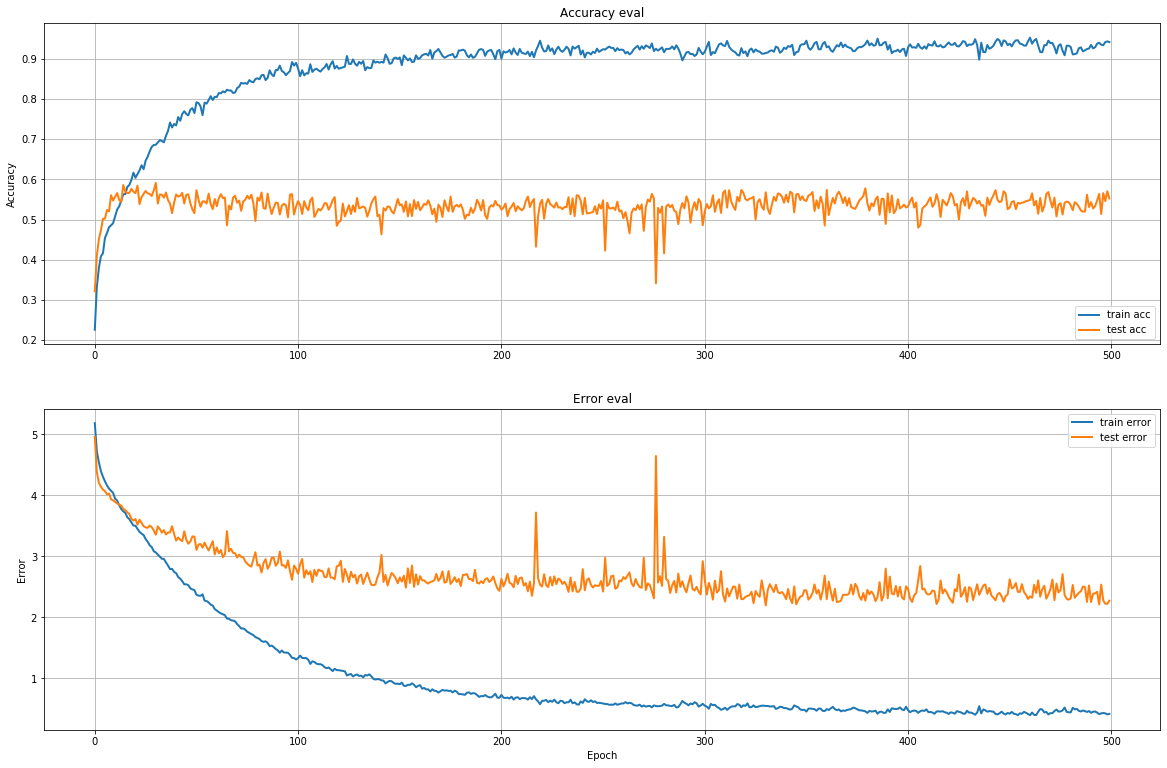

In [77]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=500)
plot_history(history)

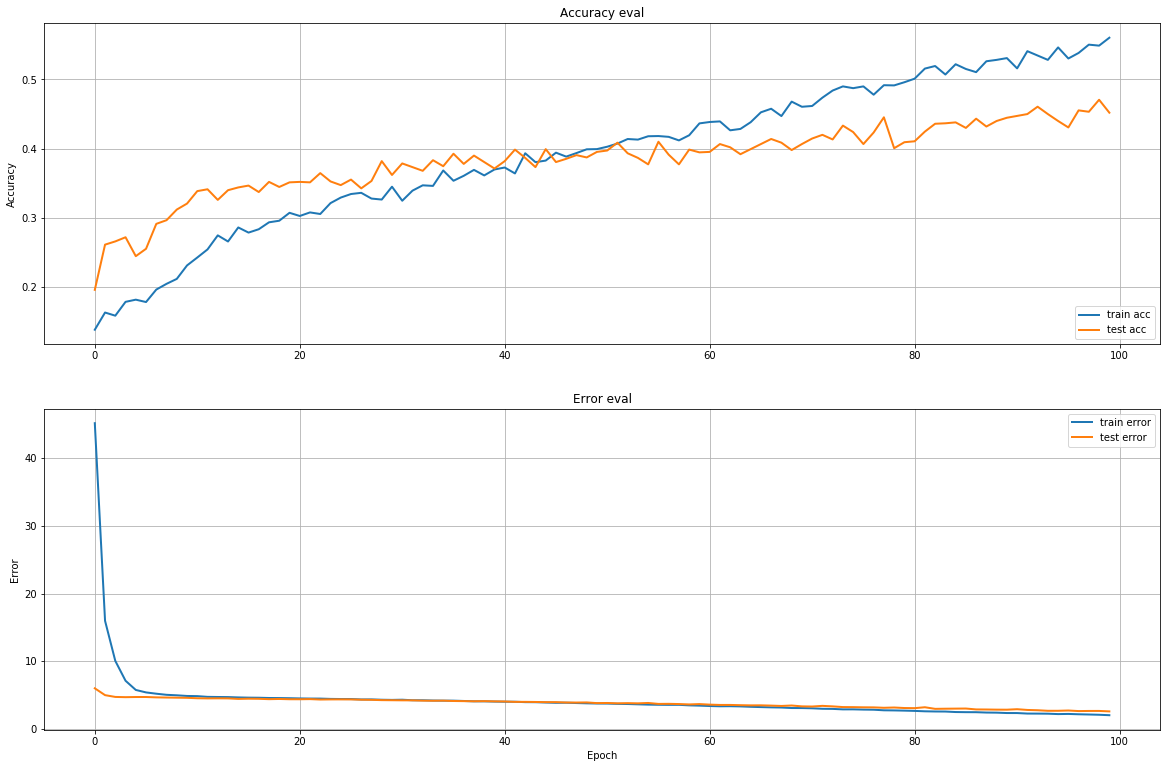

In [59]:
plot_history(history)

In [0]:
with open(DATA_PATH, "r") as fp:
  data = json.load(fp)

In [9]:
type(data)

dict

In [0]:
X = np.array(data["mfcc"])
y = np.array(data["labels"])

In [15]:
X.shape

(4998, 259, 13)

In [20]:
X

9